# STA 208 Project: CNNs and Bandwidth

The folowing is the code for the project. In the first few cells we import the common libraries and classes for the experiments.

Import libraries

In [0]:
from __future__ import print_function

#tesnsorflow
import tensorflow as tf

#keras
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model,Sequential
from keras.datasets import cifar10

#other
import time
import os


#plot
import matplotlib.pyplot as plt
import numpy as np


#sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#BW
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm

import numpy as np
from sklearn.decomposition import PCA
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras.utils import to_categorical
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt


Using TensorFlow backend.


BW calculation - To calculate the average bandwidth of a set of images we calculated the total number of bytes required for the  loss less transmission of the set of images and calculated the average. For this, first we mapped the pixel/coefficient values of the dataset to a dictionary and calculated the frequency of each codeword. Then we generated binary strings to represent each codeword with **Huffman encoding**. To make sure that the codewords are integers, we quantized the pixel/coefficient values and used these quantized coefficients for later processes like reconstruction and classification. This way the effect of quantization is also reflected on the classification accuracy.

In [0]:
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
  
def HuffmanBW(x_test):
    """ input: x_test
        output: average BW/image in Bytes
    """
    bitstream=0
    for imnum in range(0,x_test.shape[0]):
        img = x_test[imnum,]
        bitcount=0
        
        if(np.min(img) < 0):
            img = img - np.min(img)
        if(np.max(img)==0):
            img[0,0]=1
            
        txt = "".join(map(chr, img.flatten()))
        symb2freq = defaultdict(int)
        
        for ch in txt:
            symb2freq[ch] += 1
      
        huff = encode(symb2freq)
      ##### Calculating the number of bits needed
    
        for p in huff:
            bitcount = bitcount+  symb2freq[p[0]]*len(p[1])
        bitstream = bitstream + bitcount
    BW = np.round(bitstream/(x_test.shape[0]*8))            ## BW in bytes
    return BW

Data augmentation

By randomly changing the images of each minibatch can help to solve the overfitting problem. For this,  we used the following custom data augmentation generator to randomly flip and shift the training images.

In [0]:
def creategen(X,Y,batch_size):
    while True:
        # suffled indices    
        #idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
                
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)

        batches= datagen.flow( X, Y, batch_size=batch_size,shuffle=True)
       
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            temp = batch[0].astype('float32')
            #waveletmy2.batchwaveletcdf97mat(batch[0].astype('float32'),M,16)
            #temp = waveletmy2.batchwaveletsArrange(temp)
            
            yield temp/np.max(np.abs(temp)) , batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

Learning rate scheduler -  We used an initial learning rate of 0.001 which is reduced progressively at 80, 120, 160 and 180 over 200 epochs.

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-2
    elif epoch > 160:
        lr *= 1e-2
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

Resnet - Following is the code for ResNet. We started with keras example code for CIFAR-10 and and changes as necessary. **copy the description from the report**

In [0]:
n=1 #this is an indicator or depth (See keras Resnet implementation for CIFAR-10 for more details)
#the following are the n values of the models a,b,c,d,e,f
#a: n= 4
#b: n= 3
#c: n= 2
#d: n= 3
#e: n= 2
#f: n= 1

depth = n * 6 + 2 #model depth

# Model name, depth and version
model_type = 'ResNet%d' % (depth)

def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3, ######################### try to change this and see
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10,num_filters=16,pool_size=8):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = num_filters
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,num_filters = num_filters)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters  = int(num_filters*1.5)

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Faster and more accurate classification

Assume a cloud based image classification scenario. Here source device (mobile phone) sends an inference image over a bandlimited channel to the server to get the class label. Server receives the inference image and feeds it to a trained classifier to predict the class label. In order to conserve limited channel bandwidth and storage capacity, 
source devices often encode and compress the images before transmitting to the cloud by utilizing standardized
compression techniques such as JPEG2000.Because most neural networks are designed to classify images in the spatial RBG domain, the cloud currently receives and decodes the compressed j2k images back into the RGB domain before forwarding them to trained neural networks for further processing, as illustrated in the top part of the follwing figure. Thus, a natural question arises is to how to achieve faster training and inference with improved accuracy in a cloud based image classification under bandwidth, storage and computation constraints. 
	

<img src="files/figures/j2kcoder2.jpg">

We claim that the conventional use of image reconstruction is unnecessary for JPEG2000 encoded classification by constructing and training a deep CNN model with the DWT coefficients with CDF 9/7 wavelets. See the bottom part of the above figure. Furthermore, we establish that more accurate classification is also possible by deploying shallower models to benefit from faster training and classification in comparison to models trained fo spatial RGB image inputs. 

# Experiment 1

We trained a set of ResNet models for CIFAR-10 dataset and following figures compare the test accuracy and speed for training and inference process. 

<img src="files/figures/result12.JPG">

In the above figure, (a) illustrates test accuracy vs inference speed for the CIFAR-10 data set. The blue lines represent results using reconstructed RGB images. Red curve is the result using DWT coefficients with CDF 9/7 wavelets. (b) shows the Test error vs training speed/epoch. Here rate is the number of images that go through the model in each epoch.  The proposed model delivers fast and accurate classification for both training and inference. The points a,b,c,d,e and f correspond to 6 different ResNet models. The following table summerices these models.

<img src="files/figures/tabelresnet.JPG">

Following is the code for the above implementation.

We used the following ResNet model (reference - keras). For each model a,b,c,d,e and f, we changed the number of residual blocks (n). For RGB domain we started with the number of filters 16 and doubled the number of filters as we downsample the input. For DWT domain we start with 64 filters and increased them by a factor of 1.5 as we down sample the input. The reason the different treatments for different domain is the number of channels and input height and width for the different domain. RGB inputs are 32x32x3 and DWT inputs are 16x61x12.

we used the following methods for preprocessing to follow the JEPG2000 encoder as closely as possible. Following are the steps.
- Level offset : deduct 128 from the inputs
- Convert RGB to YCbCr color space
- Take DWT with CDF 9/7 wavelets - we implement this linear transformation as a matrix multiplication.
- divide the input by the maximum absolute value to normalize. (why - works best with DWT according to literature)

Following are the methods.

In [0]:
from numpy.linalg import inv

#RGB2YCbCr - RGB to YCbCr conversion
def batchRGB2YCRCB(x_batch):
    alpha_R = 0.299
    alpha_G = 0.587
    alpha_B = 0.114
    x_batchnew = np.zeros((x_batch.shape)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        #Y
        x_batchnew[i,:,:,0] = alpha_R*x_batch[i,:,:,0] + alpha_G*x_batch[i,:,:,1] + alpha_B*x_batch[i,:,:,2]
        #Cb
        x_batchnew[i,:,:,1] = (0.5/(1-alpha_B))*(x_batch[i,:,:,2]-x_batchnew[i,:,:,0])
        #Cr
        x_batchnew[i,:,:,2] = (0.5/(1-alpha_R))*(x_batch[i,:,:,0]-x_batchnew[i,:,:,0])
    return x_batchnew


#generate the matrix for CDF 9/7 transform
def getTcdf97(height):
    a1 = -1.586134342
    a2 = -0.05298011854
    a3 = 0.8829110762
    a4 = 0.4435068522

    # Scale coeff:
    k1 = 0.8128662109 # 1/1.230174104914 // 0,2,4,6
    k2 = 0.6149902344 # 1.230174104914/2 // 5038 1,3,5,7
    X1 = np.identity(height)
    X2 = np.identity(height)
    X3 = np.identity(height)
    X4 = np.identity(height)
    X5 = np.zeros((height,height)).astype('float32')
    for col in range(1,height-2,2):
        X1[col-1,col]=X1[col+1,col]=a1
    X1[height-2,height-1] = 2*a1
    
    #print(X1)
    for col in range(2,height-1,2):
        X2[col-1,col]=X2[col+1,col]=a2
    X2[1,0] = 2*a2
    #print(X2)
    for col in range(1,height-2,2):
        X3[col-1,col]=X3[col+1,col]=a3
    X3[height-2,height-1] = 2*a3
    
    #print(X1)
    for col in range(2,height-1,2):
        X4[col-1,col]=X4[col+1,col]=a4
    X4[1,0] = 2*a4
    
    for col in range(0,height,1):
        if(col%2==0 ):
            #print(col)
            X5[col,int(col/2)]=k1
        else:
            X5[col,int(height/2 + (col-1)/2)]=k2
    #print(X3)
    X =np.matmul(np.matmul(np.matmul(np.matmul(X1,X2),X3),X4),X5)
    return X,inv(X)

#take Level 1 DWT
def batchwaveletcdf97mat(x_batch,X,dimhalf):
    x_batchnew = np.zeros((x_batch.shape[0],dimhalf,dimhalf,12)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        for j in range(0,x_batch.shape[3]):
            coeff_array = np.matmul(np.matmul(X.transpose(),x_batch[i,:,:,j]),X)
            x_batchnew[i,:,:,j*4+0]=coeff_array[0:dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+1]=coeff_array[0:dimhalf,dimhalf:2*dimhalf]
            x_batchnew[i,:,:,j*4+2]=coeff_array[dimhalf:2*dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+3]=coeff_array[dimhalf:2*dimhalf,dimhalf:2*dimhalf]
    return x_batchnew

Load the dataset and preprocessing - we used CIFAR-10 for all the experiemnts.

In [0]:
# Load the CIFAR10 data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
#convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


#level offset
X_train = X_train - 128.0
X_test = X_test - 128.0

#RGB2YCbCr - This converts RGB images to YCbCr format to facilitate compression - optional
X_train = batchRGB2YCRCB(X_train)
X_test = batchRGB2YCRCB(X_test)

#generate necessary matrices for DWT cdf9/7 trandformation
M,M_inv = getTcdf97(32)

#take level-1 DWT with CDF 9/7
x_train = batchwaveletcdf97mat(X_train.astype('float32'),M,16)
x_test = batchwaveletcdf97mat(X_test.astype('float32'),M,16)

### max normalization
x_train=x_train/np.max(np.abs(x_train))
x_test=x_test/np.max(np.abs(x_test))

input_shape = x_test.shape[1:]
print('input shape to resnet: ',input_shape)

input shape to resnet:  (16, 16, 12)


Convert labels to one hot encoding

In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Compile the model: we used Adam optimizer with batchsize 32. Original resnet paper uses 128 but we have limited GPU memory.

In [0]:
batch_size = 32  
epochs = 1#200

model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes,num_filters=64,pool_size=4)

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 12)   0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   6976        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

Set callback methods

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

Train the model - We used a server with Titan-V GPU. (We train only for 1 epoch to show the code works. We used 200 epochs to train both RGB and  DWT and models)

In [0]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(creategen(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0]/32.0)),
                        epochs=epochs, verbose=1, workers=1,
                        callbacks=callbacks)

Epoch 1/1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50000, 16, 16, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Learning rate:  0.001
   2/1563 [..............................] - ETA: 37:56 - loss: 3.3381 - acc: 0.1250  

10. Evaluate the test set - The results below is after 1 eopoch.(to show the code works)

In [0]:
start = time.time()
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Experiment 2.1 (RGB)

The most basic test for dimensionality reduction will be RGB. Three channels are used for pictures in CIFAR10 dataset consisting of 32 x 32 images.


In [0]:
#Code for NN
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#set RGB ResNet-8 parameters
image_size = 32
channel_num = 3
max_image = 255

epochs = 200
batch_size = 32

170500096/170498071 [==============================] - 2s 0us/step


For RGB testing of accuracy and bandwidth, first designate function for calling the ResNet-8 function in a closed-off manner.

In [0]:
def ResCNN(x_train,y_train,x_test,y_test):
    
    #normalize data
    x_train = x_train.astype('float32') / max_image

    x_test = x_test.astype('float32') / max_image
    
    #set labels to numerical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #set more ResNet-8 parameters
    input_shape = x_train.shape[1:]
    depth = 8
    
    #set number of labels
    num_classes = 10
    
    #call model from resnet_v1
    model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
    
    #set learning rate
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

    callbacks = [lr_reducer, lr_scheduler]
    
    model.fit_generator(creategen(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0]/32.0)),
                        epochs=epochs, verbose=1, workers=1,
                        callbacks=callbacks) 
    
    #evaluate model
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    return test_loss, test_acc

In [0]:
#find accuracy and loss for ResNet-8
test_loss_Resnet, test_acc_Resnet = ResCNN(x_train,y_train,x_test,y_test)
print(test_acc_Resnet)

Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
Learning rate:  0.001
 469/1563 [========>.....................] - ETA: 35s - loss: 1.8305 - acc: 0.3449

Next proccess labels and images for PCA reduction.

In [0]:
#fit model with PCA

#flatten
x_train_pca = x_train.reshape(x_train.shape[0],-1).astype('float32')
x_test_pca = x_test.reshape(x_test.shape[0],-1).astype('float32')

#use sklearn's pca tool to set up pca object
pca = PCA(0.99)

#fit all data
pca.fit_transform(x_train_pca)

#find projection matrix
x_train_pca_proj = pca.fit_transform(x_train_pca)

#reconstruct image
x_train_recon = pca.inverse_transform(x_train_pca_proj)

#reshape reconstructed image
x_train_recon = x_train_recon.reshape(x_train.shape).astype('float32')

#same as above for test images
x_test_pca_proj = pca.fit_transform(x_test_pca)
x_test_recon = pca.inverse_transform(x_test_pca_proj)
x_test_recon = x_test_recon.reshape(x_test.shape).astype('float32')

In [0]:
#find test accuracy and loss for PCA ResNet-8
test_loss_Resnet_PCA, test_acc_Resnet_PCA = ResCNN(x_train_recon,y_train,x_test_recon,y_test)
print(test_acc_Resnet_PCA)

NameError: ignored

Now show the first few pca components.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

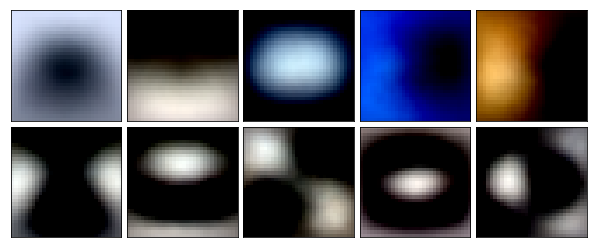

In [0]:
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca.components_[i,:]/np.max(pca.components_[i,:]), (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

Display original RGB image (Red)

Original images:


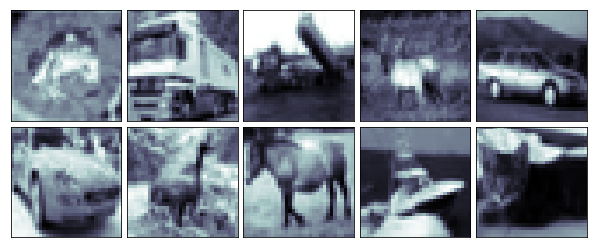

In [0]:
#show original images
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('Original images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train[i,:,:,0]/np.max(x_train[i,:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

Show reconstructed image after PCA. Notice how similar they look even with fewer components.

reconstructed images:


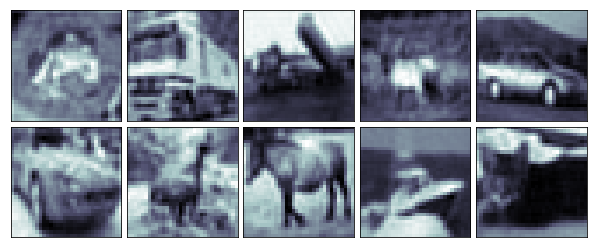

In [0]:
#recon images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_recon[i,:,:,0]/np.max(x_train_recon[i,:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

Doing the bandwidth calculations,

In [0]:
BWtest = HuffmanBW(x_test)
BWtrain = HuffmanBW(x_train)
BWtest_PCA = HuffmanBW(x_test_pca_proj)
BWtrain_PCA = HuffmanBW(x_train_pca_proj)

print(BWtest)
print(BWtrain)
print(BWtest_PCA)
print(BWtrain_PCA)

# Experiment 2.2 (DCT)

We will also be applying a discrete cosine transform to the images to see the effect of this transform on the accuracy.

In [0]:
# DCT
from scipy.fftpack import dct, idct

def reduce_data(x_train, y_train, x_test, y_test, n, m):
    return (x_train[:n], y_train[:n]) , (x_test[:m], y_test[:m])

In [0]:
#Code for NN
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Reduce data for code testing
#(x_train, y_train), (x_test, y_test) = reduce_data(x_train, y_train, x_test, y_test, 500, 100)

#set RGB ResNet-8 parameters
image_size = 32
channel_num = 3
max_image = 255

epochs = 200
batch_size = 32

In [0]:
#Apply DCT
divisions = 8
x_train_dct = x_train.reshape(x_train.shape[0],int(image_size/divisions),int(image_size/divisions),channel_num*divisions*divisions).astype('float')
x_test_dct = x_test.reshape(x_test.shape[0],int(image_size/divisions),int(image_size/divisions),channel_num*divisions*divisions).astype('float')

# Apply DCT to each channel separately
for channel in range(x_train_dct.shape[-1]):
  x_train_channel = x_train_dct[:,:,:,channel]
  x_train_dct[:,:,:,channel] = dct(x_train_channel.reshape(x_train_channel.shape[0],-1), norm='ortho').reshape(x_train_channel.shape)
  
  x_test_channel = x_test_dct[:,:,:,channel]
  x_test_dct[:,:,:,channel] = dct(x_test_channel.reshape(x_test_channel.shape[0],-1), norm='ortho').reshape(x_test_channel.shape)

print(x_train_dct.shape)
x_train_dct = x_train_dct.reshape(x_train.shape)
x_test_dct = x_test_dct.reshape(x_test.shape)
print(x_train_dct.shape)

(50000, 4, 4, 192)
(50000, 32, 32, 3)


reconstructed images:


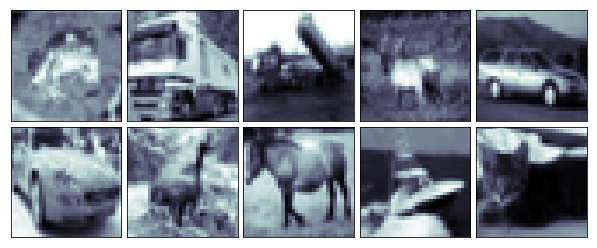

In [0]:
# Reconstruct images after DCT
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 32 by 32 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    image = x_train_dct[i,:,:]
    image_i = image.reshape(int(image_size/divisions),int(image_size/divisions),divisions*divisions*channel_num)
    for channel in range(image_i.shape[-1]):
      image_i[:,:,channel] =  idct(image_i[:,:,channel].reshape(-1),norm='ortho').reshape(int(image_size/divisions),int(image_size/divisions))
    image_i = image_i.reshape(image.shape)
    ax.imshow(np.reshape(image_i[:,:,0]/np.max(image_i[:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

In [0]:
#fit model with PCA

#flatten
x_train_dct_flat = x_train_dct.reshape(x_train_dct.shape[0],-1).astype('float32')
x_test_dct_flat = x_test_dct.reshape(x_test_dct.shape[0],-1).astype('float32')

#use sklearn's pca tool to set up pca object
pca_dct = PCA(0.99)

#find projection matrix
x_train_dct_pca_proj = pca_dct.fit_transform(x_train_dct_flat)

#reconstruct image
x_train_dct_recon = pca_dct.inverse_transform(x_train_dct_pca_proj)

#reshape reconstructed image
x_train_dct_recon = x_train_dct_recon.reshape(x_train.shape).astype('float32')

#same as above for test images
x_test_dct_pca_proj = pca_dct.transform(x_test_dct_flat)
x_test_dct_recon = pca_dct.inverse_transform(x_test_dct_pca_proj)
x_test_dct_recon = x_test_dct_recon.reshape(x_test_dct.shape).astype('float32')

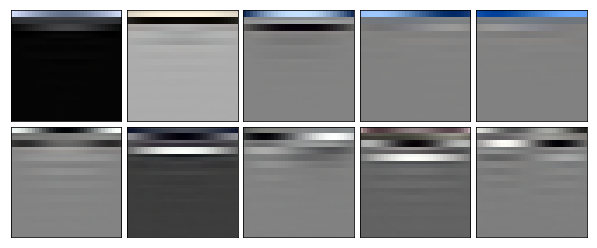

In [0]:
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    image = pca_dct.components_[i,:]
    im_max = np.amax(image)
    im_min = np.amin(image)
    image = (image-im_min)/(im_max-im_min)
    ax.imshow(np.reshape(image, (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

reconstructed images:


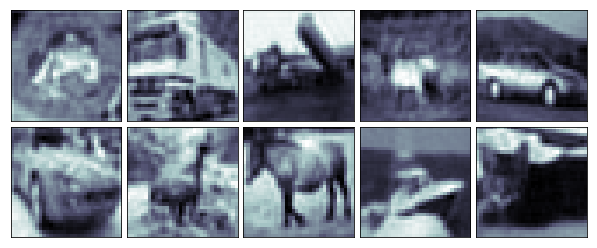

In [0]:
# Reconstruct images after DCT and PCA
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 32 by 32 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    image = x_train_dct_recon[i,:,:]
    image_i = image.reshape(int(image_size/divisions),int(image_size/divisions),divisions*divisions*channel_num)
    for channel in range(image_i.shape[-1]):
      image_i[:,:,channel] =  idct(image_i[:,:,channel].reshape(-1),norm='ortho').reshape(int(image_size/divisions),int(image_size/divisions))
    image_i = image_i.reshape(image.shape)
    ax.imshow(np.reshape(image_i[:,:,0]/np.max(image_i[:,:,0]), (32,32)), cmap=plt.cm.bone, interpolation='nearest')

In [0]:
BWtest = HuffmanBW(x_test_dct_flat)
BWtrain = HuffmanBW(x_train_dct_flat)
BWtest_PCA = HuffmanBW(x_test_dct_pca_proj)
BWtrain_PCA = HuffmanBW(x_train_dct_pca_proj)

print(BWtest)
print(BWtrain)
print(BWtest_PCA)
print(BWtrain_PCA)

2886.0
2886.0
603.0
603.0


In [0]:
#Find accuracy and loss with DCT
test_loss_Resnet_dct, test_acc_Resnet_dct = ResCNN(x_train_dct, y_train, x_test_dct, y_test)
print('Test loss:', test_loss_Resnet_dct)
print('Test accuracy:', test_acc_Resnet_dct)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 1262s 807ms/step - loss: 1.6103 - acc: 0.4341
Epoch 2/200
Learning rate:  0.001


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1563/1563 [==============================] - 1219s 780ms/step - loss: 1.3559 - acc: 0.5304
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 1214s 776ms/step - loss: 1.2709 - acc: 0.5640
Epoch 4/200
Learning rate:  0.001
1563/1563 [==============================] - 1211s 775ms/step - loss: 1.2116 - acc: 0.5863
Epoch 5/200
Learning rate:  0.001
1563/1563 [==============================] - 1210s 774ms/step - loss: 1.1734 - acc: 0.6012
Epoch 6/200
Learning rate:  0.001
1563/1563 [==============================] - 1203s 769ms/step - loss: 1.1406 - acc: 0.6128
Epoch 7/200
Learning rate:  0.001
1563/1563 [==============================] - 1208s 773ms/step - loss: 1.1132 - acc: 0.6239
Epoch 8/200
Learning rate:  0.001
1563/1563 [==============================] - 1204s 771ms/step - loss: 1.0941 - acc: 0.6312
Epoch 9/200
Learning rate:  0.001
1563/1563 [==============================] - 1209s 774ms/step - loss: 1.0759 - acc: 0.6393
Epoch 10/200
Learning rate:  0.001

Now we apply PCA to the DCT data.

In [0]:
#find test accuracy and loss for DCT and PCA ResNet-8
test_loss_Resnet_dct_PCA, test_acc_Resnet_dct_PCA = ResCNN(x_train_dct_recon,y_train,x_test_dct_recon,y_test)
print('Test loss:', test_loss_Resnet_dct_PCA)
print('Test accuracy:', test_acc_Resnet_dct_PCA)

Learning rate:  0.001
Epoch 1/1
Learning rate:  0.001
16/16 [==============================] - 41s 3s/step - loss: 2.4152 - acc: 0.0938


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


100/100 [==============================] - 11s 113ms/step
Test loss: 14.421277961730958
Test accuracy: 0.08


# Experiment 2.3 (DWT)

In this experiment we start with Level 1 DWT coefficents with CDF 9/7 wavelet and explore methods to reduce the required bandwidth () 
in cloud based image classification. To create a baseline, we train a ResNet-8 with quantized CDF 9/7 DWT coefficients BW
and measure the classification accuracy of CIFAR-10 dataset (say $a_1$) and calculate the BW with Huffman encoding. (Say $BW_1$). Then we perform a principal component analysis (PCA) on the vectorized dataset to reduce the dimentionality of data with the perpose of reducing bandwidth. We can calculate the average BW of these quantized PCA projections (say $BW_2$). Then we reconstruct the wavelet coefficients to the original dimension and train a ResNet-8 to obtain $a_2$ accuracy. We observed that $BW_2$ is much smaller than $BW_1$ and $a_1$ and $a_2$ are considerably close.

This observation implies than we can save bandwidth by only sending the projected DWT coefficients rather than sending the complete image
with a negligible accuracy loss. We can apply this in to practice like this. We can do a PAC analysis on a large dataset like
ImageNet and store the principal components at the server. Source device can calculate the projections and transmit these projections
consuming smaller BW. At the server end, high dimentional image can be reconstructed using the stored PCA coefficients and feed to 
a classifier.

We obtained the following results.

| Method | Test Accuracy (%) | Bandwidth (Bytes) |
| --- | --- | --- |
| Original DWT quantized | 90 | 1552 |
| PCA DWT quantized | 90 | 317 |

Following is the code for the implementation.
Let's load the data set and calculate PCA components

In [0]:
#import libraries

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

We used the following Huffman encoder to calculate the required BW

In [0]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm

Load CIFAR-10, tahe DWT and flatten the data for PCA

In [0]:
# Load the CIFAR10 data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
#convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


#level offset
X_train = X_train - 128.0
X_test = X_test - 128.0

#RGB2YCbCr - This converts RGB images to YCbCr format to facilitate compression - optional
X_train = batchRGB2YCRCB(X_train)
X_test = batchRGB2YCRCB(X_test)

#generate necessary matrices for DWT cdf9/7 trandformation
M,M_inv = getTcdf97(32)

#take level-1 DWT with CDF 9/7
x_train = batchwaveletcdf97mat(X_train.astype('float32'),M,16)
x_test = batchwaveletcdf97mat(X_test.astype('float32'),M,16)

#flattening for PCA
x_train_ori = x_train.copy()
x_train_ori = x_train_ori.astype('float32')
x_test_ori = x_test.copy()
x_test_ori = x_test_ori.astype('float32')
x_train = x_train.reshape(x_train.shape[0],-1).astype('float32')
x_test = x_test.reshape(X_test.shape[0], -1).astype('float32')

input_shape = x_train_ori.shape[1:]
print('input shape to resnet: ',input_shape)
print('Dataset shape after vectorizing: ',x_train.shape)

input shape to resnet:  (16, 16, 12)
Dataset shape after vectorizing:  (50000, 3072)


Calculate PCA and choose the components to preserve 99% of the variance 

In [0]:
pca = PCA(0.99)
x_train_proj= pca.fit_transform(x_train)
x_train_proj = np.floor(x_train_proj/5)*5 #quantization

x_test_proj= pca.transform(x_test)
x_test_proj = np.floor(x_test_proj/5)*5


print('original representation',x_train.shape)
print('reduced representation: ',x_train_proj.shape)

original representation (50000, 3072)
reduced representation:  (50000, 687)


With PCA we reduced the feature size from 3072 to 687. Let's display the first few principal compenents.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

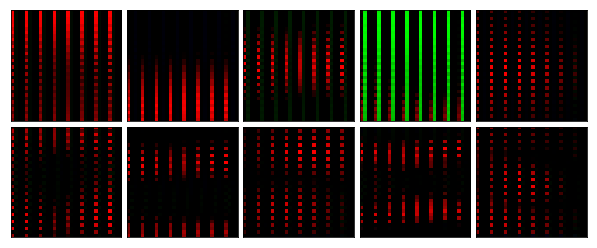

In [0]:
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca.components_[i,:]/np.max(pca.components_[i,:]), (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

Now recontruct the images after dim reduction.For the display purposes we only show the 1st subband of 12 subbands of the images.

Original images:
reconstructed images:


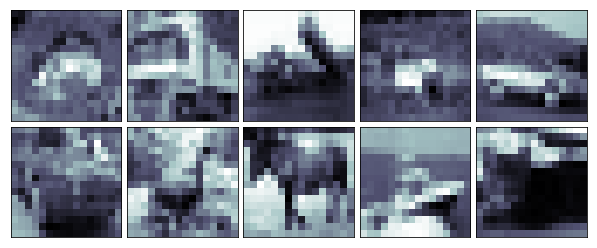

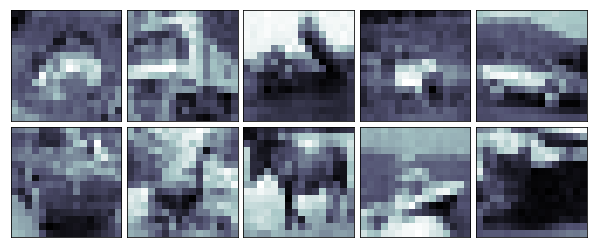

In [0]:
x_train_recon = pca.inverse_transform(x_train_proj)
x_train_recon = x_train_recon.reshape(x_train_ori.shape)

x_test_recon = pca.inverse_transform(x_test_proj)
x_test_recon = x_test_recon.reshape(x_test_ori.shape)

#show original images
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('Original images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_ori[i,:,:,0]/np.max(x_train_ori[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  
#recon images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
print('reconstructed images:')
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.reshape(x_train_recon[i,:,:,0]/np.max(x_train_recon[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  

Origianal and reconstructured images look similar. Now we can calculate $BW_1$ and $BW_2$.

$BW_1$

In [0]:
BWr = HuffmanBW(np.floor(x_train_ori).astype('int32'))
print('original images avg.BW/image: ',str(BWr),' Bytes')

original images avg.BW/image:  1552.0  Bytes


$BW_2$

In [0]:
BWp = HuffmanBW(x_train_proj.astype('int32'))
print('projections avg.BW/image: ',str(BWp),' Bytes')

projections avg.BW/image:  317.0  Bytes


Now lets train the network to obtain $a_2$.

In [0]:
### max normalization
x_train=x_train_recon/np.max(np.abs(x_train_recon))
x_test=x_test_recon/np.max(np.abs(x_test_recon))

input_shape = x_test.shape[1:]
print('input shape to resnet: ',input_shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

input shape to resnet:  (16, 16, 12)


Complile the ResNet-8 model

In [0]:
batch_size = 32  
epochs = 1

model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=10,num_filters=64,pool_size=4)

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16, 16, 12)   0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 16, 16, 64)   6976        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 16, 16, 64)   256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 16, 16, 64)   0           batch_normalization_22[0][0]     
_______________________________________________________________________________________

Set call backs and fit. (We train only for 1 epoch to show the code works. We used a Titan_V GPU with 200 epochs to train both original DWT and PCA models)

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(creategen(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0]/32.0)),
                        epochs=epochs, verbose=0, workers=1,
                        callbacks=callbacks)

c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50000, 16, 16, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Learning rate:  0.001


c:\users\lahiru d. chamain\anaconda3\envs\tfgpumy\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Evaluate the testSet after 1 epoch.

In [0]:
start = time.time()
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=0)
print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

time per image : 0.2656890869140625  ms
Test loss: 1.3354834184646607
Test accuracy: 0.5856
